# Race-Memory Project Analysis Pipeline (v1)

### Load everything
Libraries, custom functions, and data

In [5]:
import math
import numpy as np
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import json
import scipy.stats as sp
import sklearn as sk
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from ast import literal_eval
from IPython.display import Markdown as md
import re, os
data_path = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/main/'
pd.options.mode.chained_assignment = None 
import warnings ; warnings.filterwarnings('ignore')

In [6]:
# import custom functions
import functions as fun
meta = fun.load_metadata() # just in case

In [7]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# load data
files = [i for i in os.listdir(data_path) if i.startswith('taskdata')]
df_list = []
for f in files:
    if f != 'taskdata_chris_main_task_2_prolific_afc3_20_05_2022.csv':
        df_list.append(pd.read_csv(data_path + f))
df = pd.concat(df_list)

df2 = pd.read_csv(data_path + 'taskdata_chris_main_task_2_prolific_afc3_20_05_2022.csv')
w = df2[(df2.trial_type == 'demographics') & (df2.race.str.contains('White'))].experiment_id.to_numpy()
b = df2[(df2.trial_type == 'demographics') & (df2.race.str.contains('Black'))].experiment_id.to_numpy()
df = pd.concat([df, df2[df2.experiment_id.isin(w)]])

In [9]:
# fill in tilt_difference and tilt_change
for i in range(len(df)):
    if 'retrieval' in df.trial_type.iloc[i]:
        if pd.isna(df.tilt_difference.iloc[i]) and not pd.isna(df.old_tiltLR.iloc[i]) and not pd.isna(df.old_original_tiltLR.iloc[i]):
            tilt = fun.get_tilt_change(df.old_original_tiltLR.iloc[i], df.old_tiltLR.iloc[i])
            df['tilt_difference'].iloc[i] = tilt['difference']
            df['tilt_change'].iloc[i] = tilt['change']  

In [10]:
df['tilted'] = (df['tilt_difference'] != 0) & ( (df['trial_type'] == 'retrieval') | (df['trial_type'] == 'retrieval_practice') )  
df.loc[df.trial_type.str.contains('retrieval'), 'response'] = pd.to_numeric(df.loc[(df['trial_type'] == 'retrieval') | 
                                          (df['trial_type'] == 'retrieval_practice'), 
                                          'response'])

In [11]:
## PROLIFIC IDS THAT CONFIRMED HAD GLITCH
exclude = [
    '5e68682ce3b2f71041fa03d2', 
    '610d170f7bb4e720cb85b6b2',
    '580bea98827ca10001db514e',
    '60ba71aa8f2ae12d3a595982'
]
df = df[~df.subject_id.isin(exclude)]
print('EXPERIMENT IDS EXCLUDED:', '\n', exclude)

EXPERIMENT IDS EXCLUDED: 
 ['5e68682ce3b2f71041fa03d2', '610d170f7bb4e720cb85b6b2', '580bea98827ca10001db514e', '60ba71aa8f2ae12d3a595982']


In [12]:
# exclude nan experiment id
df = df[~pd.isna(df.experiment_id)]

In [13]:
# exclude subjects who didn't finish the experiment
df = fun.exclude_nofinish(df) 
# there are many because this contains data from a failed iteration 

EXPERIMENT IDS EXCLUDED:
 ['cqbz7lh19r6krarwzy7n', 'o1qhbw4lrfpx8jk9vyxn', 'y9krtso6fmwtl2u13csl', 'e79drsrtw4392byd7eem', '184gl7o42b9bdl9e6xsm', 'xpyxc6uu5ea54nd1fu5p', '4mc72sfz921j7s6hgvkm', 'urxm6qqdbsataccvjjcm', 'socq4e5100dn03j66xdr', 'f4qdjdd8mr5gm6djqcn9', 'coar15q7qjjbfusnr6yb']


In [14]:
# also, exclude subjects who show terrible performance: wrong on a practice 5 times in a row
df = fun.exclude_practice(df, max_wrong = 5)
# also, exclude subjects who timed out on everything
df = fun.exclude_timeout(df)

EXPERIMENT IDS EXCLUDED:
 ['as2pyeoy9jc2lf00v2w6']
EXPERIMENT IDS EXCLUDED:
 ['g51c2p98lpbc8zxstqra', 'akn81dwp3vhwnstj0wmb']


In [89]:
just_white_subjects = True
if just_white_subjects:
    old_df = df.copy()
    df_white = df[df.experiment_id.isin(
        df[df.race == "['White']"].experiment_id.unique()
    )]

no_black_subjects = True
b_ids = df[(df.trial_type == 'demographics') & (df.race.str.contains('Black'))].experiment_id.unique()
if no_black_subjects:
    old_df = df.copy()
    df = df[~df.experiment_id.isin(b_ids)]

In [88]:
df_orig = df.copy()
df = fun.age_filter(df)

EXPERIMENT IDS EXCLUDED:
 []


In [90]:
print('# of participants remaining:')
print(len(df.experiment_id.unique()))

# of participants remaining:
135


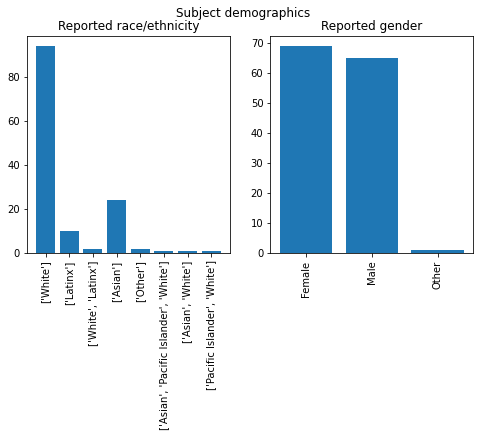

["['White']" "['Latinx']" "['White', 'Latinx']" "['Asian']" "['Other']"
 "['Asian', 'Pacific Islander', 'White']" "['Asian', 'White']"
 "['Pacific Islander', 'White']"]
[94, 10, 2, 24, 2, 1, 1, 1]
69 women, 65 men


In [91]:
fun.demographics_plot(old_df)

In [54]:
print('Age range: ' + str(df.age.min()) + " - " + str(df.age.max()))
print('Median age: ' + str(df.age.median()))

Age range: 18.0 - 59.0
Median age: 26.0


## Subject-Level Analysis

summary - encoding, filler, and retrieval accuracy and RT

In [70]:
def results(data):
    data_dist = data[~pd.isna(data.ret_dist_delta)]
    
    print('\n--Encoding--')
    print('accuracy by race:')
    print(sp.wilcoxon(data.enc_acc_delta))
    print('RT by race:')
    print(sp.wilcoxon(data.enc_rt_delta))
    print('RT vs. accuracy:')
    print(sp.linregress(x=data.enc_rt, y=data.enc_acc))
    
    print('\n--Retrieval--')
    print('accuracy by tilt:')
    print(sp.wilcoxon(data.ret_acc_0, data.ret_acc_50))
    print('accuracy by race:')
    print(sp.wilcoxon(data.ret_acc_w, data.ret_acc_b))
    print('dist by race:')
    print(sp.wilcoxon(data_dist.ret_dist_w, data_dist.ret_dist_b))
    print('accuracy by tilt * race:')
    print(fun.show_model_parameters(smf.ols("accuracy ~ tilt * race", data = {
        'accuracy': np.concatenate([data.ret_acc_w_0, data.ret_acc_b_0, 
                                    data.ret_acc_w_50, data.ret_acc_b_50]), 
        'tilt': np.concatenate([np.repeat(0, 2*len(data)), np.repeat(1, 2*len(data))]),
        'race': np.concatenate([np.repeat(1, len(data)), np.repeat(0, len(data)), 
                                np.repeat(1, len(data)), np.repeat(0, len(data))])
        }),md_bool=False))

    print('\n--Encoding-Retrieval--')
    print('∆enc_rt vs ∆ret_acc')
    print(sp.linregress(x=data.enc_rt_delta, y=data.ret_acc_delta))
    print('∆enc_acc vs ∆ret_acc')
    print(sp.linregress(x=data.enc_acc_delta, y=data.ret_acc_delta))
    print('∆enc_rt vs ∆ret_dist')
    print(sp.linregress(x=data_dist.enc_rt_delta, y=data_dist.ret_dist_delta))
    print('∆enc_acc vs ∆ret_dist')
    print(sp.linregress(x=data_dist.enc_acc_delta, y=data_dist.ret_dist_delta))
    
def results_split(data):
    data_dist = data[~pd.isna(data.ret_dist_delta)]
    
    print('\n--Encoding--')
    print('accuracy by group:')
    print(sp.wilcoxon(data.enc_acc_delta))
    print('RT by group:')
    print(sp.wilcoxon(data.enc_rt_delta))

    print('\n--Retrieval--')
    print('accuracy by group')
    print(sp.wilcoxon(data.ret_acc_low, data.ret_acc_high))
    print('dist by group')
    print(sp.wilcoxon(data_dist.ret_dist_low, data_dist.ret_dist_high))
    print('accuracy by tilt*group')
    print(fun.show_model_parameters(smf.ols("accuracy ~ tilt * rt_group", data = {
        'accuracy': np.concatenate([data.ret_acc_low_0, data.ret_acc_high_0, 
                                    data.ret_acc_low_50, data.ret_acc_high_50]), 
        'tilt': np.concatenate([np.repeat(0, 2*len(data)), np.repeat(1, 2*len(data))]),
        'rt_group': np.concatenate([np.repeat(1, len(data)), np.repeat(0, len(data)), 
                                np.repeat(1, len(data)), np.repeat(0, len(data))])
        }),md_bool=False))

    print('\n--Encoding-Retrieval--')
    print('∆enc_rt vs ∆ret_acc')
    print(sp.linregress(x=data.enc_rt_delta, y=data.ret_acc_delta))
    print('∆enc_acc vs ∆ret_acc')
    print(sp.linregress(x=data.enc_acc_delta, y=data.ret_acc_delta))
    print('∆enc_rt vs ∆ret_dist')
    print(sp.linregress(x=data_dist.enc_rt_delta, y=data_dist.ret_dist_delta))
    print('∆enc_acc vs ∆ret_dist')
    print(sp.linregress(x=data_dist.enc_acc_delta, y=data_dist.ret_dist_delta))
    
    
def ret_model(data):
    
    model = smf.ols("accuracy ~ tilt * race", data = {
        'accuracy': np.concatenate([data.ret_acc_w_0, data.ret_acc_b_0, 
                                    data.ret_acc_w_50, data.ret_acc_b_50]), 
        'tilt': np.concatenate([np.repeat(0, 2*len(data)), np.repeat(1, 2*len(data))]),
        'race': np.concatenate([np.repeat(1, len(data)), np.repeat(0, len(data)), 
                                np.repeat(1, len(data)), np.repeat(0, len(data))])
        })
    
    print(model.fit().params)
    print(model.fit().tvalues)
    print(model.fit().pvalues)
    
def ret_model_split(data):
    
    model = smf.ols("accuracy ~ tilt * rt_group", data = {
        'accuracy': np.concatenate([data.ret_acc_low_0, data.ret_acc_high_0, 
                                    data.ret_acc_low_50, data.ret_acc_high_50]), 
        'tilt': np.concatenate([np.repeat(0, 2*len(data)), np.repeat(1, 2*len(data))]),
        'rt_group': np.concatenate([np.repeat(1, len(data)), np.repeat(0, len(data)), 
                                np.repeat(1, len(data)), np.repeat(0, len(data))])
        })
    print(model.fit().params)
    print(model.fit().tvalues)
    print(model.fit().pvalues)
    
    
    
    

In [56]:
stats_enc_corr = fun.get_stats(df, only_correct_encoding=True)
stats_enc_split = fun.get_encoding_split_stats(df, only_correct_encoding = True)

In [71]:
results(stats_enc_corr)
ret_model(stats_enc_corr)
results_split(stats_enc_split)
ret_model_split(stats_enc_split)


--Encoding--
accuracy by race:
WilcoxonResult(statistic=2539.5, pvalue=0.036410952411180315)
RT by race:
WilcoxonResult(statistic=2535.5, pvalue=6.414932517474971e-06)
RT vs. accuracy:
LinregressResult(slope=2.491840321605481e-05, intercept=0.7259984704211913, rvalue=0.20198000777842348, pvalue=0.018811810726502946, stderr=1.047711019915431e-05, intercept_stderr=0.03259341696547397)

--Retrieval--
accuracy by tilt:
WilcoxonResult(statistic=1688.5, pvalue=2.378625115996285e-09)
accuracy by race:
WilcoxonResult(statistic=2537.5, pvalue=2.607455434329821e-05)
dist by race:
WilcoxonResult(statistic=2437.0, pvalue=0.0001407961899959988)
accuracy by tilt * race:
$\beta = -0.02$, $F(3, 536)$ = $-0.56, P = 0.576 $

--Encoding-Retrieval--
∆enc_rt vs ∆ret_acc
LinregressResult(slope=-5.065109792334656e-06, intercept=-0.08360252029329912, rvalue=-0.012498446091035486, pvalue=0.8855999250346422, stderr=3.513768121272247e-05, intercept_stderr=0.019361851596162664)
∆enc_acc vs ∆ret_acc
LinregressRes

In [126]:
smf.ols("y ~ x", data = {
    "y": stats_enc_corr.enc_rt,
    "x": stats_enc_corr.ret_rt
}).fit().pvalues

Intercept    1.275663e-05
x            6.371898e-15
dtype: float64

In [118]:
stats_enc_corr.ret_acc_w_0

0      0.666667
1      0.571429
2      0.555556
3      0.571429
4      0.250000
         ...   
130    1.000000
131    0.500000
132    0.571429
133    0.875000
134    0.714286
Name: ret_acc_w_0, Length: 135, dtype: float64

In [122]:
smf.ols("acc ~ race*tilt", data = {
    "acc": np.concatenate([
        stats_enc_corr.ret_acc_w_0,
        stats_enc_corr.ret_acc_b_0,
        stats_enc_corr.ret_acc_w_50,
        stats_enc_corr.ret_acc_b_50,
    ]),
    "race": np.concatenate([
        np.zeros(len(stats_enc_corr)),
        np.ones(len(stats_enc_corr)),
        np.zeros(len(stats_enc_corr)),
        np.ones(len(stats_enc_corr)),
    ]),
    "tilt": np.concatenate([
        np.zeros(2*len(stats_enc_corr)),
        np.ones(2*len(stats_enc_corr)),
    ])
}).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    acc   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     22.31
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           1.26e-13
Time:                        13:10:46   Log-Likelihood:                 129.22
No. Observations:                 540   AIC:                            -250.4
Df Residuals:                     536   BIC:                            -233.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6097      0.016     37.055      0.000       0.577       0.642
race           0.0744      0.023      3.197      0.001       0.029       0.120
tilt          -0.1143      0.023     -4.913      0.000      -0.160      -0.069
race:tilt      0.0184      0.033      0.559      0.576      -0.046       0.083
==============================================================================
Omnibus:                        6.529   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.397
Skew:                          -0.233   Prob(JB):                       0.0408
Kurtosis:                       2.742   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
sp.wilcoxon(np.nanmean([stats_enc_corr.ret_acc_0_enc_50L, stats_enc_corr.ret_acc_0_enc_50R], axis=0),
            np.nanmean([stats_enc_corr.ret_acc_50_enc_50L, stats_enc_corr.ret_acc_50_enc_50R], axis=0))





WilcoxonResult(statistic=1847.0, pvalue=3.4945958551446335e-08)

In [124]:
sp.ttest_1samp(stats_enc_corr.ret_acc_delta, popmean=0)


Ttest_1sampResult(statistic=-4.6313063859643195, pvalue=8.49606386390371e-06)

In [134]:
fun.show_ols_parameters(stats_enc_corr.enc_rt_delta, 
                        stats_enc_corr.ret_acc_delta)


$\beta = -0.00$,  $F(1, 133)$ = $-0.14,  P = 0.886 $

In [114]:
stats_enc_corr.ret_acc.mean()

0.5939718148680251

-0.0825338571657801

# Final thesis figures

In [78]:
sp.ttest_1samp(stats_enc_split.ret_acc_delta, popmean=0).pvalue

0.013008146549323453

In [79]:
save_bool = True
slider_bool = False

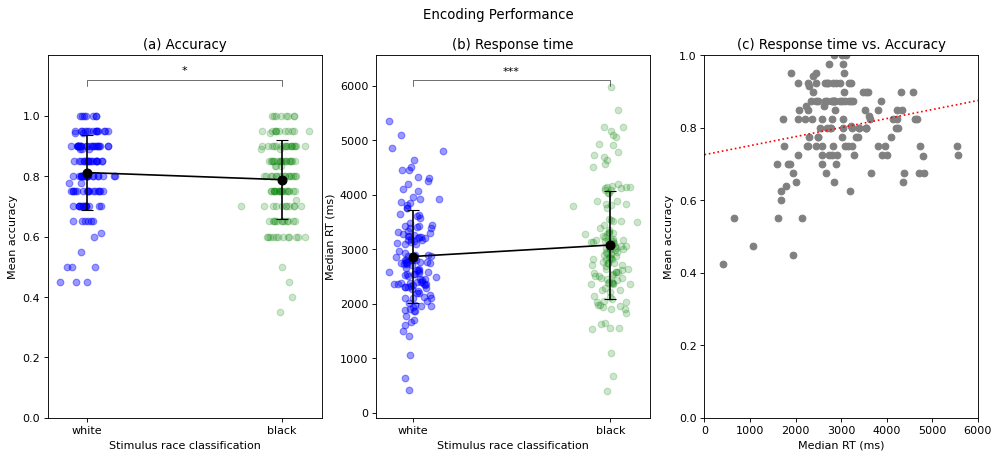

In [80]:
fun.encoding_plot(stats_enc_corr, save = save_bool)

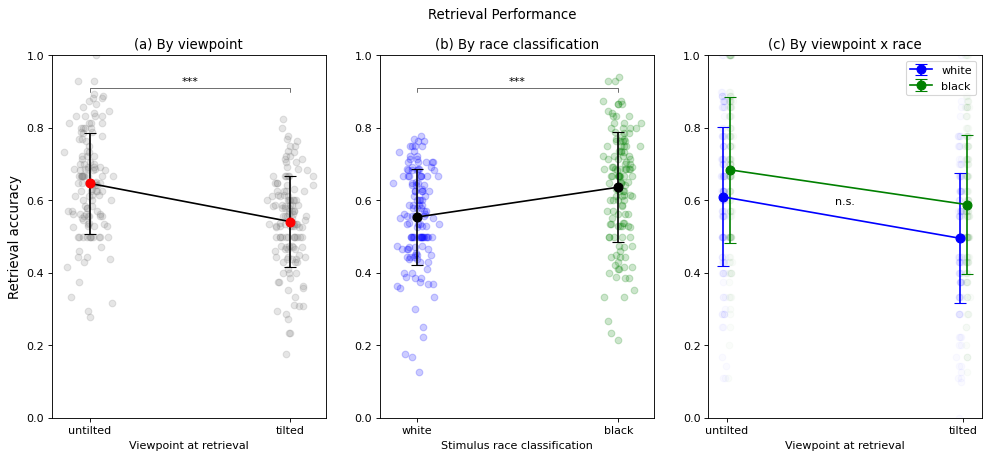

In [81]:
fun.retrieval_plots(stats_enc_corr, save = save_bool)

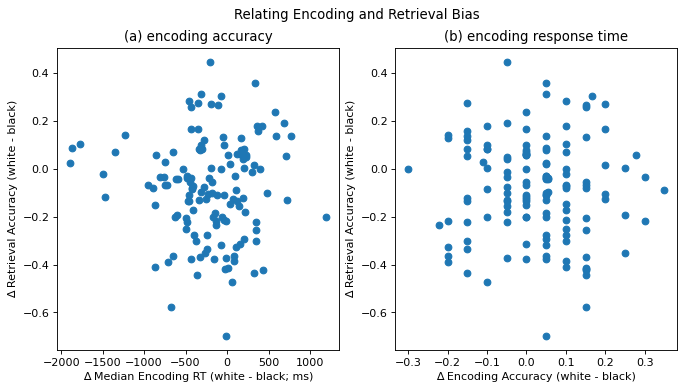

In [82]:
fun.encoding_delta_plot(stats_enc_corr, save = save_bool)

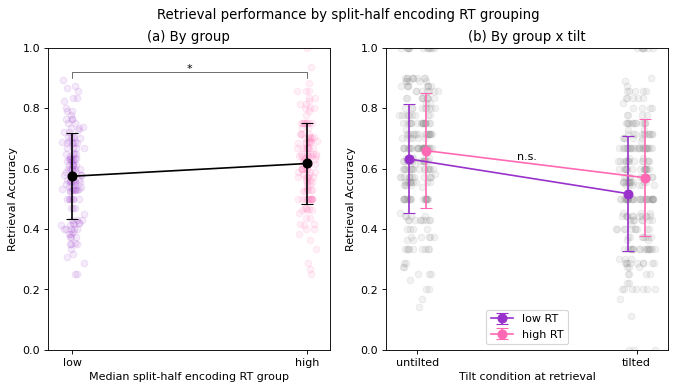

Test for panel A: 
 WilcoxonResult(statistic=3362.0, pvalue=0.027268521975120197)
Test for panel B: 
 $\beta = 0.03$, $F(3, 536)$ = $0.77, P = 0.441 $


In [83]:
fun.retrieval_split_plot(stats_enc_split, save = save_bool)

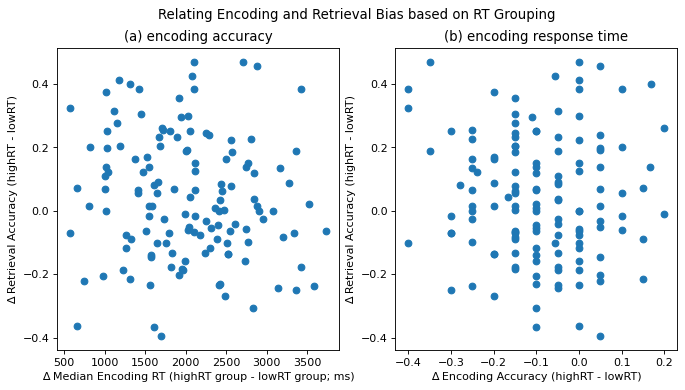

In [84]:
fun.encoding_split_delta_plot(stats_enc_split, save = save_bool)